In [1]:
#import functions
import numpy as np
from numpy import linalg

import cv2 as cv
import scipy
from scipy import signal

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
import shutil

from utils import resize_percent, edge_detect, count_gray_levels, fill
# from utils import show_image

In [108]:
#cross correlation function

def cross_correlation (frNum, path_to_images, pixel, kernel, x_disp=False, y_disp=False):
    image_1_name = os.fsdecode(os.listdir(path_to_images)[0])
    image_1 = cv.imread(path_to_images + f'{image_1_name}', cv.IMREAD_GRAYSCALE)
    corr_full_x = np.zeros([image_1.shape[1], frNum])
    corr_full_y = np.zeros([image_1.shape[0], frNum])
    k=0
    while k<frNum:
        image_name = str(k) + '.jpg'
        image_next = cv.imread(path_to_images+f'{image_name}', cv.IMREAD_GRAYSCALE)
        if x_disp:
            arr_1 = np.ones([kernel,]) * image_1[pixel[0], pixel[1]]
            corr = signal.correlate(image_next[pixel[0], :], arr_1, mode='same')
            corr = np.reshape(cv.normalize(corr, None, 1, 256, cv.NORM_MINMAX), (image_1.shape[1],)) #normalization added
            corr_full_x[:, k] = corr
        if y_disp:
            arr_1 = np.ones([kernel,]) * image_1[pixel[0], pixel[1]]
            corr = signal.correlate(image_next[:, pixel[1]], np.transpose(arr_1), mode='same')
            corr = np.reshape(cv.normalize(corr, None, 1, 256, cv.NORM_MINMAX), (image_1.shape[0],)) #normalization added
            corr_full_y[:, k] = corr          
        k+=1
    
    return corr_full_x, corr_full_y

In [102]:
'''Cropping the images''' 

'- data_path: path to the folder with the images to crop'
'- data_save: path to the folder to save the cropped images'
'- x_start: a starting x coordinate to crop an image'
'- x_end: an ending x coordinate to crop an image'
'- y_start: a starting y coordinate to crop an image'
'- y_end: an ending y coordinate to crop an image'
'- color: indicate if the images to crop are colored'

def crop_images(data_path, data_save, x_start, x_end, y_start, y_end, color=False):
    for image in os.listdir(data_path):
        image_name = os.fsdecode(image)
        if color:
            img_next = cv.imread(data_path+f'{image_name}', cv.IMREAD_COLOR)
            cropped_img = img_next[x_start : x_end, y_start : y_end, :]
            cv.imwrite(data_save + f'{image_name}', cropped_img)
        else:
            img_next = cv.imread(data_path+f'{image_name}', cv.IMREAD_GRAYSCALE)
            cropped_img = img_next[x_start : x_end, y_start : y_end]
            cv.imwrite(data_save + f'{image_name}', cropped_img)

In [103]:
# #ONLY RUN ONCE
# #making folders
os.mkdir('exp_2perc')
os.mkdir('exp_2perc_crop')

In [104]:
# #ONLY RUN ONCE
# #extracting frames from the simulated 2 percent G1100 video
video_name = 'Result of 20kHz_400mV_100kfps_384by240_20x_C001H001S0001-cut_50fr_subs-cleaned'
path_to_source = 'data/' + video_name + '.avi'
cap = cv.VideoCapture(path_to_source)
num_frames = 50
l=0
m=0
while l <= num_frames:
    ret, frame = cap.read()
    if not ret: 
        print('No frames grabbed!')
        break
    cv.imwrite(f'exp_2perc/{m}.jpg', frame)
    l+=1
    m+=1

[ WARN:0@8031.891] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_5a1v4y7k9y/croot/opencv-suite_1676472757237/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@8031.891] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_5a1v4y7k9y/croot/opencv-suite_1676472757237/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_5a1v4y7k9y/croot/opencv-suite_1676472757237/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




No frames grabbed!


In [105]:
# #ONLY RUN ONCE
# # crop images for faster calculation 
data_path = 'exp_2perc/'
data_save = 'exp_2perc_crop/'
x_start = 0
x_end = 100
y_start = 0
y_end = 20
crop_images(data_path, data_save, x_start, x_end, y_start, y_end, color=False)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


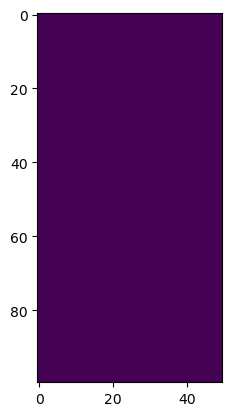

In [111]:
# implement slope measurement for one pixel
# 100x100 pixels
#iterate through each pixel to get a correlation result
frNum = 50
# path_to_images = 'sim_2perc_crop/'
# path_to_images = 'sim_1perc_crop/'
# path_to_images = 'sim_05perc_crop/'
path_to_images = 'exp_2perc_crop/'
kernel = 1
threshold_bin = 0

pixel_x = 8
pixel_y = 1
pixel_array = []
for x in range(0, pixel_x + 1):
     for y in range(0, pixel_y + 1):
        pixel = [pixel_x, pixel_y]
pixel_array.append(pixel)         
         
#corr_full_y is 100x29 matrix which represents one pixel      
_, corr_full_y = cross_correlation(frNum, path_to_images, pixel_array[0], kernel, x_disp=False, y_disp=True)

plt.imshow(corr_full_y)
# print(corr_full_y.shape[1])
print(corr_full_y[:,-1])

[[0. 1. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0.

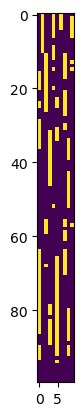

In [107]:
#clean version
T=120
image = np.copy(corr_full_y)
image[corr_full_y<T] = 0
image[corr_full_y>=T] = 1
plt.imshow(image)
print(image)

In [99]:
non0_firstCol = np.argwhere(image[:,0]==1)
zero_lastCol = np.argwhere(image[:,-1]==0)
print(non0_firstCol[0])
print(zero_lastCol[-1])
slope = (zero_lastCol[-1] - non0_firstCol[0])/frNum
print(slope)


[11]
[37]
[2.6]


[[0.         0.         0.         ... 0.79610976 0.96311231 0.99467192]
 [0.         0.         0.         ... 0.75810668 0.95463268 0.99327982]
 [0.         0.         0.         ... 0.71259645 0.94447797 0.99161272]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]


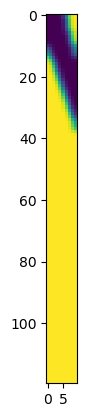

In [100]:
img = image.copy()
img_bl = cv.GaussianBlur(src=img, ksize=(7, 7), sigmaX=1)
plt.imshow(img_bl)
print(img_bl)

In [5]:
# Save the Numpy array as Image
image_filename = "image0_2perc.jpeg"
i=0
saved_image = plt.imsave(fname=image_filename, arr=image)

In [ ]:
img = cv.imread(filename=image_filename, flags=cv.IMREAD_GRAYSCALE)
plt.imshow(image)
print(image)

2.2766820580474936


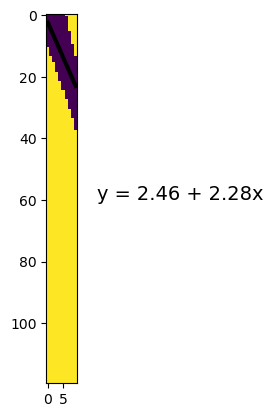

In [101]:
#example: fitting a line to cross correlation clean version from above (flipped)
plt.imshow(image)
#finding where the value is zero in the image matrix and filling that region with scatter points
zero_coords = np.argwhere(image==0)
# plt.xlim(0,10)
# plt.ylim(0,80)
# plt.scatter(zero_coords[:,1],zero_coords[:,0], color='purple')

#find line of best fit for scatter
slope, b = np.polyfit(zero_coords[:,1], zero_coords[:,0], 1)
if slope<0:
    zero_coords = np.argwhere(image==1)
    slope, b = np.polyfit(zero_coords[:,1], zero_coords[:,0], 1)
else:
    slope = slope


#add line of best fit to plot
plt.plot(zero_coords[:,1], slope*zero_coords[:,1]+b, color='black', linestyle='-', linewidth=3)

#add fitted regression equation to plot
plt.text(16, 60, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(slope) + 'x', size=14)
print(slope)